# Predicting Popularity on Spotify

This example uses the <a href="https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks">publicly-available Spotify from Kaggle</a> to predict the popularity of Polish songs and artists on Spotify. We'll also use a model to group artists together based on how similar their songs are.<br><br>You can download the Jupyter notebook of this study <a href="spotify.ipynb">here</a>.

The "tracks" dataset (tracks.csv) have the following features: 
<ul class="ul_content">
    <li>id represents the Id of the track generated by Spotify</li>
</ul>

Numerical:
<ul class="ul_content">
    <li>acousticness (range: [0,1]) </li>
    <li>danceability (range: [0,1]) </li>
    <li>energy, (range: [0,1]) </li>
    <li>duration_ms (range: [200000,300000]) </li>
    <li>instrumentalness (range: [0,1]) </li>
    <li>valence (range: [0,1]) </li>
    <li>popularity (range: [0,100]) </li>
    <li>tempo (range: [50,150]) </li>
    <li>liveness (range: [0,1]) </li>
    <li>loudness (range: [-60,0]) </li>
    <li>speechiness (range: [0,1]) </li>
</ul>

Dummy:
<ul class="ul_content">
    <li>mode (0 = Minor, 1 = Major)</li>
    <li>explicit (0 = No explicit content and 1 = Explicit content)</li>
</ul>

Categorical:
<ul class="ul_content">
    <li>key - keys on an octave encoded as integers in range [0,11] (C = 0, C# = 1, etc.)</li>
    <li>timesignature - predicted time signature</li>
    <li>artists - list of contributing artists</li>
    <li>artists - list of IDs of contributing artists</li>
    <li>release_date - date of release (yyyy-mm-dd)</li>
    <li>name - track name</li>
</ul>

The "artists" dataset (artists.csv) has the following features:
<ul class="ul_content">
    <li>id - ID of the artist</li>
    <li>name - artist name</li>
    <li>followers - how many followers the artist has</li>
    <li>popularity - popularity of the artists based on their tracks</li>
    <li>genres - list of genres covered by the artist's tracks</li>
</ul>

### Import libraries

Start by importing VerticaPy and loading the SQL extension, which allows you to query the Vertica database with SQL.

In [1]:
import verticapy as vp
%load_ext verticapy.sql

This example uses the following version of VerticaPy:

In [2]:
vp.__version__

'0.9.0'

Connect to Vertica. This example uses an existing connection called "VerticaDSN." For details on how to create a connection, use see the <a href="../../connection.php">connection tutorial</a>.

In [3]:
vp.connect("VerticaDSN")

Create a new schema, "spotify."

In [4]:
vp.drop("spotify", method = "schema")
vp.create_schema("spotify")

True

### Data Loading

Load the datasets into the vDataFrame with read_csv() and then view them with display().

In [5]:
# load datasets as vDataFrame objects
artists = vp.read_csv("data/artists.csv", schema = "spotify", parse_nrows = 100)
tracks  = vp.read_csv("data/tracks.csv" , schema = "spotify", parse_nrows = 100)

The table "spotify"."artists" has been successfully created.
The table "spotify"."tracks" has been successfully created.


id    followers                                  genres   \\
1      0001K3ON4ACv7hte9Jlc6o          1.0                                      []   \\
2      0001ZVMPt41Vwzt1zsmuzp      13667.0                                 ['opm']   \\
3      0001cekkfdEBoMlwVQvpLg         80.0                                      []   \\
4      0001wHqxbF2YYRQxGdbyER       6329.0               ['progressive psytrance']   \\
5      0002XY9y3JhjzTZqNCqEcv       1828.0                                      []   \\
6      00045gNg7mLEf9UY9yhD0t        829.0                       ['dutch hip hop']   \\
7      0004m70bDmySiyX0mbJMNS          0.0                                      []   \\
8      0004mMWDlIBRhLMZP3p92i          4.0                                      []   \\
9      00052qkj8osxzuMhyZA88Y          1.0                                      []   \\
10     00062105bTKjdbdc1K1UpI          0.0                                      []   \\
11     0006sHOabJ20USMjG8cWtD        705.0                                      []   \\
12     000778ICMgFxCapm7fVDAW          1.0                                      []   \\
13     0007DSGSwy4e3PdpExQESD         47.0                                      []   \\
14     0008EBLAehfRBSeStEUQmn          0.0                                      []   \\
15     0008dSXw2QjJXEg3jNl6hG          0.0                                      []   \\
16     00097QzAB3ui6aBPavao2O          0.0                                      []   \\
17     0009LMJQT62wdZVgnM4vBy         97.0                                      []   \\
18     0009v6e5hmLdAqSFTLcKry       1417.0                 ['classic russian pop']   \\
19     000AK4sjc0Np5MbCQ6JC1U         11.0                                      []   \\
20     000AreMafq1WYcwszMM61y          0.0                                      []   \\
21     000BQxIqXh6LNfsVTt703l          0.0                                      []   \\
22     000BblCiHJeKvtiq5aiHOs       1994.0                                      []   \\
23     000CkqJliuK4m3uNRl0jd2          0.0                                      []   \\
24     000Cz1Pts8aGpDLBvrc4wi        597.0                                      []   \\
25     000DEqM4VjDJIUIFJ2LNk1          0.0                                      []   \\
26     000DpPOWQC5JxdVapodOTM          0.0                                      []   \\
27     000Dq0VqTZpxOP6jQMscVL       4923.0    ['baton rouge rap', 'deep southern t   \\
28     000ESzt0wlQI41YbKYGIkf        192.0                                      []   \\
29     000EYNgg9zCfoWNtDBemdu          0.0                                      []   \\
30     000Eamfs6aR2aDr5svq1XF         26.0                                      []   \\
31     000FVR595IhUXTTTRwMgyQ          0.0                                      []   \\
32     000G2jFbXDhyuRZGw3jX0l          0.0                                      []   \\
33     000GXXsAUTgVJfJzOEMIQz          3.0                                      []   \\
34     000Gam69yUQckclDmjLvlL       1331.0                                      []   \\
35     000IpCJToEX5T7oDZtXSeW          0.0                                      []   \\
36     000JK7wzCV5X4mg3MbsuGA         17.0                                      []   \\
37     000JMMX1ZXl1WQIu9GGxCI          0.0                                      []   \\
38     000JdbKW4RCTX2eV304DDR          5.0                                      []   \\
39     000LGmf577qlcsgUZMWJLL          0.0                                      []   \\
40     000MS0paUmy5CYke9uzmAO          0.0                                      []   \\
41     000N5stG2Co67GJJeqBJpy          0.0                                      []   \\
42     000NbZqISnuKaqmw33JxTV       1418.0                     ['native american']   \\
43     000NkLnzi66UcbuTttHDqX          1.0                                      []   \\
44     000Nolc0A0ZuWkFzNYVYdU         16.0                                      []   \\
45     000OybtozoTUivAiSvHstz          3.0                         
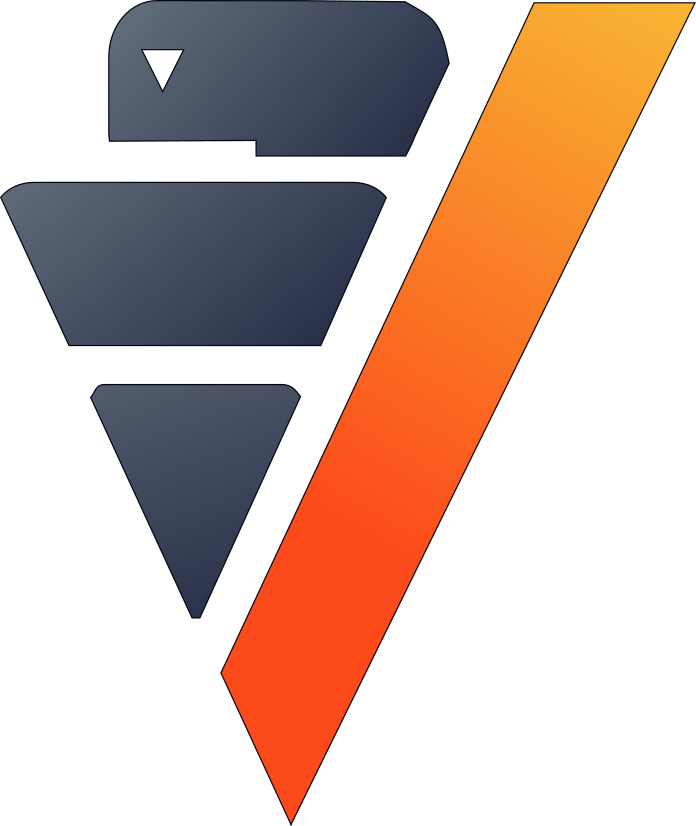

id                                      name   \\
1      0004Uy71ku11n3LMpuyf59              24.11.94 - Wersja Akustyczna   \\
2      000CSYu4rvd8cQ7JilfxhZ                               Adam et Ève   \\
3      000DsoWJKHdaUmhgcnpr8j   Balla Trazan Apansson / Vegetarianvisan   \\
4      000G1xMMuwxNHmwVsBdtj1                      Will Anything Happen   \\
5      000KblXP5csWFFFsD6smOy                                    Podrás   \\
6      000Npgk5e2SgwGaIsN3ztv                             Mere Hamsafar   \\
7      000P83HDtOHcNVFZy7Q2Yu                    El Licor de Tu Boquita   \\
8      000RDCYioLteXcutOjeweY                                Teeje Week   \\
9      000TXa2oEZLYfQGPCiv23U                                  Casanova   \\
10     000TiSS4vK5su0MkoFyQbd                                   Tenebre   \\
11     000d0lQMYaRR5ZXS9nTeiN                     Paris sous les bombes   \\
12     000jBcNljWTnyjB4YO7ojf                     Me Quieres Perjudicar   \\
13     000mGrJNc2GAgQdMESdgEc  Symphony in B-Flat Major, Op. 20: II....   \\
14     000q9YBtesW8yPwlmus12C                       Undrastrákurinn Óli   \\
15     000u1dTg7y1XCDXi80hbBX                      I Don't Want A Lover   \\
16     000x2qE0ZI3hodeVrnJK8A    (Love Me Like Music) I'll Be Your Song   \\
17     000xYdQfIZ4pDmBGzQalKU                     Eu, Você, O Mar e Ela   \\
18     000ydDsz4ijCNUsmoIeZcj                               El Cachimbo   \\
19     00105Q1NbnHkf8R5eXXeXm                             Es un Secreto   \\
20     00147h65HDYSncB3byziPP                           My Shining Hour   \\
21     0018QzCxmMrpa0FubbNdak                            Embárgame A Mi   \\
22     001AGGmHtn4FUzXgAUxz39                           Mi Larga Espera   \\
23     001GxQGaFwTjxM7tmKbMF3                         La Falla Fue Tuya   \\
24     001I9iXPNwN0HlHfdQjDIX                   El Senyor de Les Pedres   \\
25     001IcYypSE1ryXKY5KNIin                          Baby Sleep Waves   \\
26     001LvKFwYbfKYPQF2Fiv77                    Yeh Lo Main Haari Piya   \\
27     001UI3J6PKAEnBgqrwGGQC                                 Pyramania   \\
28     001UkMQHw4zXfFNdKpwXAF           Brand New Man - with Luke Combs   \\
29     001YQlnDSduXd5LgBd66gT  El Tiempo Es Dinero - Remasterizado 2007   \\
30     001ZmOPuWEW5czwun7nkha                    Would You? (End Title)   \\
31     001e2JrYMwnTeRnxf3sgIz  Violin Concerto In D, Op.35, TH. 59: ...   \\
32     001f6XLtM53gwKSauiUcKI          Tigresa - Remixed Original Album   \\
33     001gx41rQo0bKh063TrC1I                         Camino a Camagüey   \\
34     001hyVfKgE2R1a0TBXeLlV                                Adrenalina   \\
35     001s02k3baVIxp6lIVRu6k                    Yehi To Pyare Preet Ki   \\
36     00218i6cYENiDszmBKsYYg                               Gxldchainnn   \\
37     0022sbR4gAWFhpMaYLbtnX                               Anatheorisa   \\
38     0024tEymsoc9FyKUauQngQ                        To the Unknown Man   \\
39     0025JMWRhsWx0GXdlzhHMO                  Tyrant - 2016 - Remaster   \\
40     0029TH4cSnQ12KKfHaq11C                              L.A. Goodbye   \\
41     002Ac7LJjVIcfFYMZ6Irue                              Aquel Payaso   \\
42     002CcxKpBE1tfKOy2CRaWr           Teri Bhi Chup Aur Meri Bhi Chup   \\
43     002DkDzzQ7lrgaqWBF2o1M                       Snabbköpskassörskan   \\
44     002KIBXwb0pa66mPGuPKMr                     When You Don't See Me   \\
45     002TGKi4LBwxYodlfWoaN0          Cunnamulla Fella - 1998 Remaster   \\
46     002aR3zqP6SvscCnPT44on                        Binorie Variations   \\
47     002ak2fuoNB5KW0plsN1jp                                     Sally   \\
48     002c2TeuD0GPfL2ahcmWEF                        Uth Soye Huye Husn   \\
49     002dEfJAJnpoDU5cUhMmZJ                              Melodie in A   \\
50     002dh6a4LfxfGGnhPZY4fG  Paris, France / When Does This Feelin...   \\
51     002jsFzKzBLqDS71IZpnd6                                   I Dunno   \\
52     002lZtb0gYsfOJKq
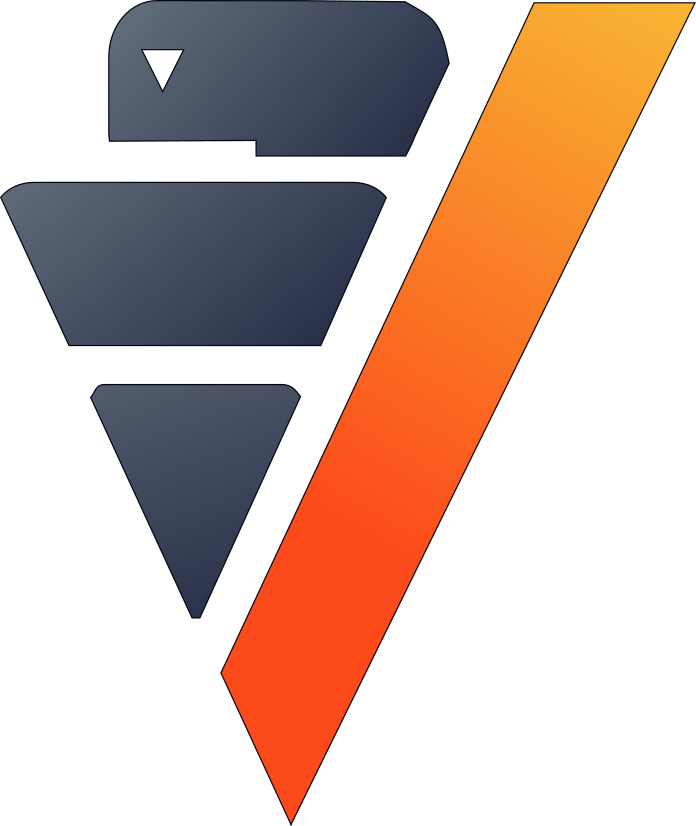

In [6]:
display(artists)
display(tracks)

## Data Exploration

The "artists" dataset is too broad for us to use right now; we're only concerned with Polish artists, so let's extract and save them to our Vertica database.

id    followers                                  genres   \\
1      004reCzVFOidvBuYrYia9Y      12726.0                         ['polish punk']   \\
2      00drc18J6PkIXn24widBC5          3.0                      ['polish ambient']   \\
3      00ekfPE5ZS3NwF8H8o8GBk      17574.0                          ['disco polo']   \\
4      0138Hlfmap3fEvKTqmZhE9       1289.0                        ['polish metal']   \\
5      018gIUaP08hROTOiVdiEQ3        584.0                  ['polish black metal']   \\
6      01BlTZ696EkKe6xr56Gu6G        362.0                    ['polish free jazz']   \\
7      01TgMAgIALWvVXlKjUwpfn       1063.0    ['polish alternative rock', 'polish    \\
8      0244q9rIqAIzBFXKNNRN6O      27393.0    ['classic polish pop', 'polish pop']   \\
9      02Cq85QmaYHDi4dW7AxTRZ        749.0                  ['polish electronica']   \\
10     02ESuuto8Jwyo4PeiJ1Xim        149.0                     ['polish synthpop']   \\
11     02JmHOSFJi2bLjGnO274di       8817.0               ['polish punk', 'szanty']   \\
12     02LrsTMdnHVvKmXxN0epQF        753.0    ['deep soundtrack', 'polish synthpop   \\
13     02eZEXslMzAjHDkygNJHSX       8010.0                         ['polish trap']   \\
14     02keDoJak6YO12KBJFMFNm       1873.0        ['polish punk', 'polish reggae']   \\
15     02tQ309SzZZ0bYs2yyO60G      11734.0                      ['polish hip hop']   \\
16     0338weYyACbkc5ERuLnFTa        270.0                  ['classic polish pop']   \\
17     033WIygOyXwUjc1vfCGxJ2        126.0                  ['polish black metal']   \\
18     03Dy3XKBUsC3vJLCuF0T7I        152.0                         ['polish jazz']   \\
19     03KLzHVK6la8dVop1iVI5x      63817.0    ['poezja spiewana', 'polish alternat   \\
20     03ZzgzybQr8UyvWCMSCvRy       1363.0                   ['polish noise rock']   \\
21     03jLJnyfZXs1ssrIALfGRm       2633.0                  ['classic polish pop']   \\
22     03ohDYwWFrXfgp0VEtSTiF        706.0                 ['polish thrash metal']   \\
23     03qKjVTzyKc3SyTjHaOpFc       2376.0      ['neo-progressive', 'polish prog']   \\
24     03rREATXGWcD2CfG3OXDZY      10155.0    ['polish alternative rap', 'polish h   \\
25     03xKZpOUZOQjf7g5WBN4ee       3676.0    ['polish alternative', 'polish indie   \\
26     03yP3BHBnpGyvddEoIGnsx       2089.0                  ['polish black metal']   \\
27     04Lio76CKJCMPbK5hV6J4w       1876.0    ['black noise', 'polish black metal'   \\
28     04Loj16dRX1yZodeEQlCOv        308.0                         ['polish jazz']   \\
29     04WxKoI0kS5JclvQ8rn8qp         13.0       ['polish contemporary classical']   \\
30     04bDWf1u7HxKdskC3N2nIk      27127.0    ['polish metal', 'polish punk', 'pol   \\
31     05AVHcWP9DF6y6LEU845uz       1545.0                  ['classic polish pop']   \\
32     05Fgqq7GfWeNol1TR5H3og      15868.0                          ['polish pop']   \\
33     05UsyksBcAUVdfyREMxbDm        295.0                          ['disco polo']   \\
34     063D0MKbIbbBjKgtYRGBga       7458.0    ['polish alternative', 'polish elect   \\
35     0690wuO0NVERuqxuoi2mTF        319.0    ['polish ambient', 'polish experimen   \\
36     06O52v4thQuBoLC6jWatGW         21.0                    ['polish free jazz']   \\
37     06UcKJxYJXthEwn0c8XOCt      11024.0    ['dark black metal', 'polish black m   \\
38     06wBGqhkbyUAtVNMbbcK1x        607.0                         ['polish folk']   \\
39     070tdNOiP3pIsGlqNfVkG3      86130.0                      ['polish hip hop']   \\
40     072HrG3T5BaaBj4YhKIkxv       1166.0             ['polish alternative rock']   \\
41     07ILo13zpakvXxTL3VtqwS        540.0                          ['disco polo']   \\
42     098RsUTij7grC7evZUhWwA        720.0                         ['polish trap']   \\
43     09MjLGtslj39ILxA1MqUny        556.0                      ['polish hip hop']   \\
44     09ScR35g0VzipHacuPtXZd        440.0                  ['polish modern jazz']   \\
45     09Z3SI4GkhYjpCB6884vC8      10395.0    ['polish alternative'
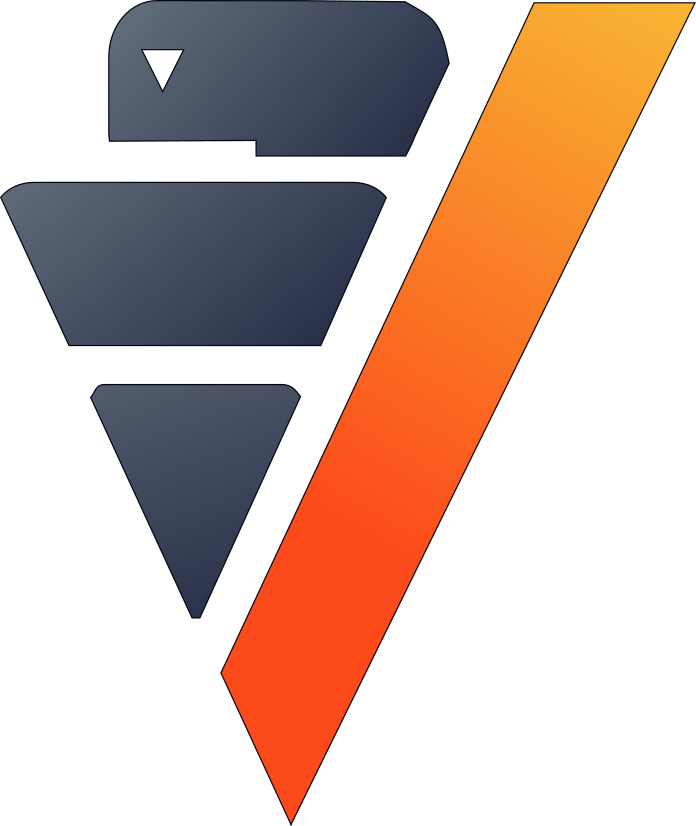

In [7]:
# filter polish artists out of the 'artists' dataset using information in 'genres' column
polish_artists = artists.search("genres ilike '%disco polo%' or genres ilike '%polish%'") 

# save it to the database
polish_artists.to_db('"spotify"."polish_artists"', relation_type = "table")

We can visualize the top 60 most-followed Polish artists with a bar chart.

In [8]:
# make a highchart of the top 60 most-followed Polish artists
polish_artists.hchart(x = "name",
                      y = "followers", 
                      aggregate = False,
                      kind = "bar",
                      max_cardinality = 60,
                      height = 900,
                      width = 1500)

We can do the same with the most popular tracks. For example, we can graph Monika Brodka's most popular tracks like so:

In [9]:
# find Monika Brodka's songs
brodka_tracks = tracks.search("artists ilike '%brodka%'")

# plot Brodka's tracks ordered by popularity
brodka_tracks.hchart(x = "name",
                     y = "popularity",
                     aggregate = False,
                     kind = "bar",
                     max_cardinality = 25) 

To get an idea of what makes Monika Brodka's songs popular, let's create a boxplot of the numerical feature distribution of her tracks.

In [10]:
## list of the relevant numerical features
numerical_features = ['danceability', 
                      'energy', 
                      'speechiness', 
                      'acousticness', 
                      'instrumentalness', 
                      'valence', 
                      'liveness'] 

# create a boxplot of the above features
brodka_tracks[numerical_features].hchart(kind = "boxplot")

Timing is a classic factor for success, so let's look at the popularity of Monika's songs over time with a smooth curve.

<AxesSubplot:xlabel='"release_date"', ylabel='"smoothed_popularity"'>

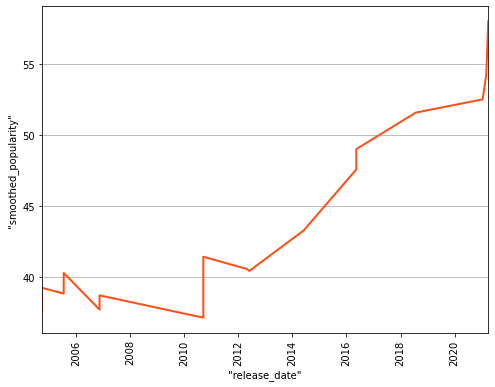

In [11]:
# extract year from the date
brodka_tracks['release_year'] = "year(release_date::date)"

# smooth the popularity using rolling mean
brodka_tracks.rolling(func = 'mean',
                      columns = 'popularity',
                      window = (-3, 3),
                      order_by = 'release_year',
                      name = 'smoothed_popularity')

# plot the smoothed curve for popularity of her songs
brodka_tracks.plot(ts = 'release_date', columns=['smoothed_popularity']) 

## Numerical-feature Analysis

Bringing it all together, let's try to get an idea of how these numerical features change and correlate with each other in Monika's most popular songs.

<AxesSubplot:xlabel='"release_year"'>

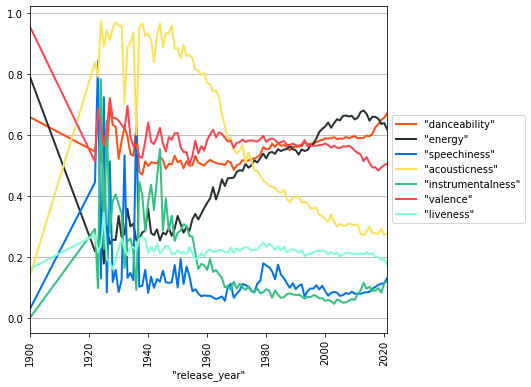

In [12]:
# extract year from date
tracks['release_year'] = "year(release_date::date)"

# get the average of numerical features during the year
yearly_aggs = tracks.groupby('release_year', ['AVG(danceability) as danceability',
                                              'AVG(energy) as energy', 
                                              'AVG(speechiness) AS speechiness', 
                                              'AVG(acousticness) AS acousticness', 
                                              'AVG(instrumentalness) AS instrumentalness',
                                              'AVG(valence) AS valence', 
                                              'AVG(liveness) AS liveness',])

# plot the cures for numerical features along the different years
yearly_aggs.plot(ts='release_year', 
                 columns=numerical_features)

"danceability"               "energy"          "speechiness"   \\
"danceability"                         1.0      0.225378443312902      0.198422110210451   \\
"energy"                 0.225378443312902                    1.0    -0.0588034003217321   \\
"speechiness"            0.198422110210451    -0.0588034003217321                    1.0   \\
"acousticness"          -0.228879028726738     -0.710939277579459     0.0735189869046661   \\
"instrumentalness"      -0.219560144635743     -0.190319675033783     -0.101150709419063   \\
"valence"                0.517690962189664      0.360195098649349     0.0439632547745622   \\
"liveness"              -0.107989997860069       0.12611905796149      0.208192661333212   \\
                              "acousticness"     "instrumentalness"                "valence"   \\
"danceability"            -0.228879028726738     -0.219560144635743        0.517690962189664   \\
"energy"                  -0.710939277579459     -0.190319675033783        0.360195098649349   \\
"speechiness"             0.0735189869046661     -0.101150709419063       0.0439632547745622   \\
"acousticness"                           1.0      0.199817518163958       -0.166786499501141   \\
"instrumentalness"         0.199817518163958                    1.0       -0.170613868369725   \\
"valence"                 -0.166786499501141     -0.170613868369725                      1.0   \\
"liveness"              -0.00448565029093398    -0.0372257235123641    -0.000143636296234245   \\
                                   "liveness"  
"danceability"             -0.107989997860069  
"energy"                     0.12611905796149  
"speechiness"               0.208192661333212  
"acousticness"           -0.00448565029093398  
"instrumentalness"        -0.0372257235123641  
"valence"               -0.000143636296234245  
"liveness"                                1.0  
Rows: 1-7 | Columns: 8
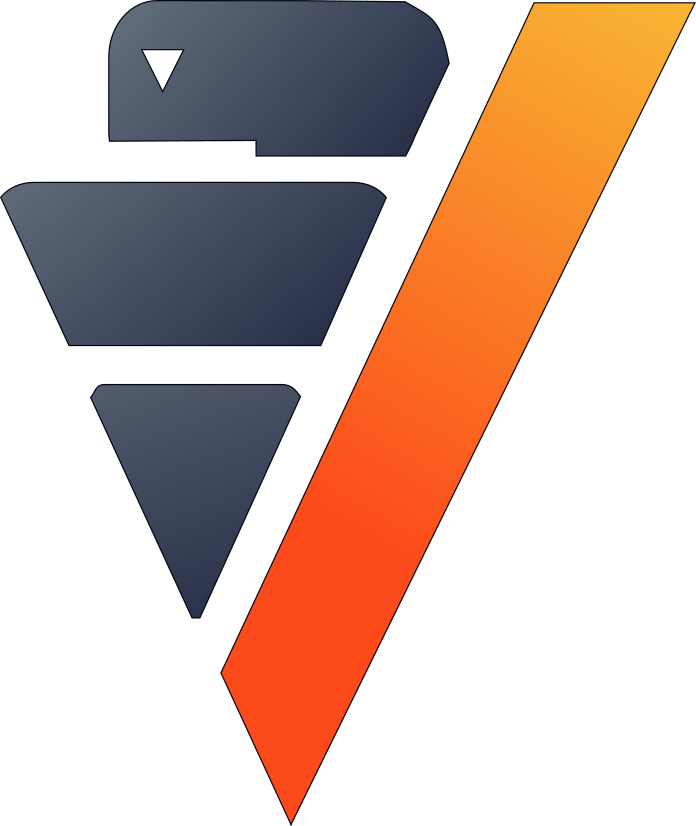

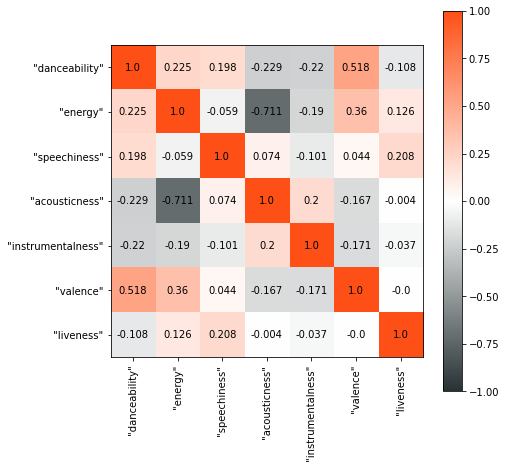

In [13]:
# correlation of numerical features
tracks[tracks[numerical_features]].corr()

# Feature Engineering

To expand our analysis, let's take into account some descriptive features. Since our goal is to predict popularity, some useful features might be:
<ul>
    <li>number of followers</li>
    <li>popularity for the artist of the track</li>
    <li>the number of artists per track</li>
</ul>

Additionally, we manipulate our data a bit to make things easier later on:
<ul>
    <li>converting the duration unit from 'ms' to 'minute'</li>
    <li>extracting the year from the date.</li>
</ul>

In [66]:
%%sql
CREATE TABLE spotify.polish_tracks AS
SELECT * FROM spotify.tracks 
WHERE id_artists IN (SELECT t.id_artists FROM spotify.tracks t JOIN spotify.polish_artists p
                     ON t.id_artists LIKE '%' || p.id || '%');
CREATE TABLE spotify.polish_tracks_clean AS
SELECT 
    x.*, 
    x.duration_ms / 60000 AS duration_minute,
    (CASE 
         WHEN LENGTH(x.release_date) = 4 THEN (release_date::INT) 
         ELSE YEAR(x.release_date::date) 
     END) AS release_year,
    y.followers AS artists_followers,
    y.popularity AS artist_popularity
FROM spotify.polish_tracks AS x LEFT JOIN spotify.artists AS y
ON x.id_artists LIKE '%' || y.id || '%';

CREATE
CREATE


id                                      name   \\
1      0004Uy71ku11n3LMpuyf59              24.11.94 - Wersja Akustyczna   \\
2      008UO76dicJJrUb5g6WID0                                       Maj   \\
3      00D7fT49Q54HNiaaLY32UA                               Arabska noc   \\
4      00De7REGurYkmfrKAh6CU1                    Dracula- The Beginning   \\
5      00KCwnrvIXX8GRU3ZMOIBW                    Désolée (Paris/Paname)   \\
6      00g7zzRDf2DOf4fKYzFTUA                                    Wiraże   \\
7      00i4Q7OfN0mGnUyuyQcAdZ  Pieseň Roxany a kadetov (Hráči mimo hry)   \\
8      00i4Q7OfN0mGnUyuyQcAdZ  Pieseň Roxany a kadetov (Hráči mimo hry)   \\
9      00l8ILQ8qgsew789dGn1Gh                                 Nyamaland   \\
10     00vlVv7WLZjyRS783REKmn                                    Upadek   \\
11     00wJpDUdKoWQ2ibqTpJh1Y                               Ze Mną Bądź   \\
12     010cqDI9IKD8f3Ji8TnT9h              Ballada o trzech trubadurach   \\
13     0123TtFcZ7pZIss52i7nAK                              Kocie Sprawy   \\
14     015JvDPIBquLQTX6VZPwB2             Kiedy znów zakwitną białe bzy   \\
15     01FN979nyz1gmdsfWZv5OL                             O Sobie Samym   \\
16     01LN8YM6L9V2a135AnhZqf                             Światłocienie   \\
17     01LN8YM6L9V2a135AnhZqf                             Światłocienie   \\
18     01j7wulLc7rJVk0STUPEKu                        Pyzate słoneczniki   \\
19     01lYEV7KZT34GOAW2MIgHF                             Jednego serca   \\
20     01uK4bh8p175iZj7uSkp5k                                   O Tobie   \\
21     025zlWO2FRZZrFhRw5kqa9                            Imperium UBOJU   \\
22     028DQ7NS44vnLRaoon0mwg                     Polska złota młodzież   \\
23     02GvdetV646M4C1Ip8CKg5               Muzyko z tamtej strony dnia   \\
24     02IpFuItRz1yXbYAtHsXJs                    Deszcz w Cisnej - 1976   \\
25     02JLJi7sryFu44hhNWOv1c                            Początek końca   \\
26     02RqhFaAYzWScfVzKfTZ7L                             Ramię W Ramię   \\
27     02hewGMWcG5Vp8nwhcmTA0                                Spalaj się   \\
28     02yg6Eksd8zZpYxsT1Lpsp                           Nie Jestem Soba   \\
29     03UV1fQG0MIm4CPszfttTJ                               Puste słowa   \\
30     04GlMx0s7MvdMr2MEXX8s8                       Kochać cię za późno   \\
31     04PxH7CFGAaAvo6j0zZAOr                                      Brać   \\
32     04PxH7CFGAaAvo6j0zZAOr                                      Brać   \\
33     04QM4iqGabg7QlphUoWiMB                     Dotyk (2020 Remaster)   \\
34     04izaHyfYxsE3AQ68kgB4I                                Barbarossa   \\
35     04kSSveBKXiNeRaOXu2iog                      Nie Ma Nie Ma Ciebie   \\
36     04wTGEh2gJTG72yUoizwFV                                 Bez szans   \\
37     053zfKbxSoqRm2RCdJdQMS                               Proletariat   \\
38     053zgCcuWJ9x4dJJgaF4VS                                Król Świtu   \\
39     054VUAvYt59A1yGSrBAgac                               Będzie dość   \\
40     05IAxc7j9T9KcEu0lAgbfB             Lubisz To Lubisz (Radio Edit)   \\
41     05JJTD8KdxbZsMnOn6imMv                 Gdzie Ten, Ktory Powie Mi   \\
42     05RcrI18Qi65dwc3vegSNP                    Echo - feat. Ewa Farna   \\
43     05hJSmfNiPXSzwSLeG1Rfb                              Czarne Serce   \\
44     05hk8ivnCt0HP3aI1uWJfi                                  Oranżada   \\
45     05v1D17vjtCNRyalBVGbKU                   Jeszcze W Zielone Gramy   \\
46     05yf5sbF36dhwGRfj18sg5                              Poland Story   \\
47     062pHiX7lpKRDmFvmJor3o               Spodnie z GS-u (The Butels)   \\
48     063FiQaY2FuZe3a44rZuSX                    Jak Dobrze Cię Widzieć   \\
49     063ZobFSzYA0O7fmfi4oik                               Pędzą Konie   \\
50     06AIE9kwssJ3cmPbMuHobb                                 Hipisówka   \\
51     06K6svVGbiQILn9BAzZNgo                               Każdy Dzień   \\
52     06LDaZRAWOc0fNqk
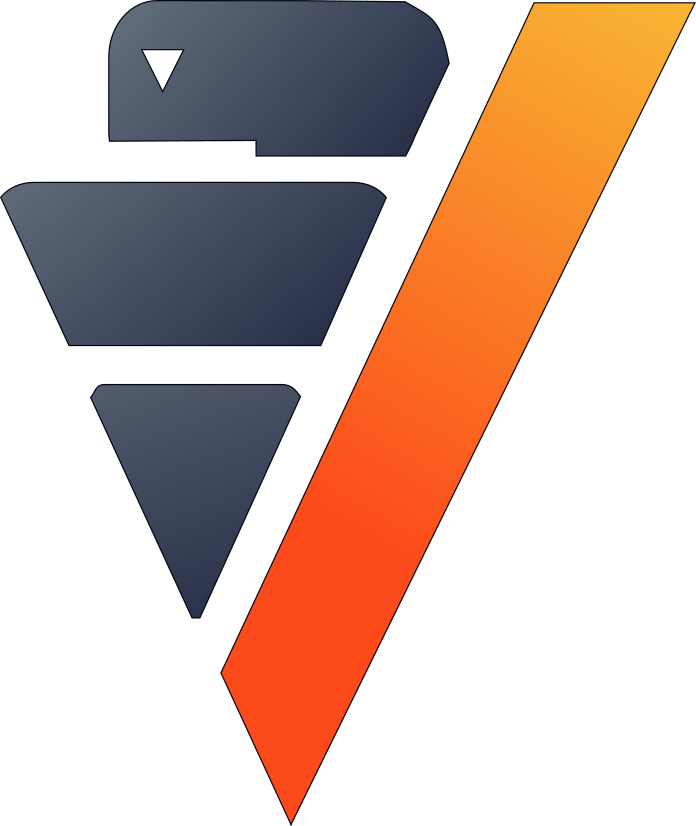

In [27]:
polish_tracks = vp.vDataFrame("spotify.polish_tracks_clean")

# count the number of artists per track
polish_tracks.regexp(column = "artists", 
                     pattern = ",", 
                     method = "count",
                     name = "nb_singers")
polish_tracks["nb_singers"].add(1)

Define a list of predictors and the response, and then save the normalized version of the final dataset to the database.

id                                      name   \\
1      0004Uy71ku11n3LMpuyf59              24.11.94 - Wersja Akustyczna   \\
2      008UO76dicJJrUb5g6WID0                                       Maj   \\
3      00D7fT49Q54HNiaaLY32UA                               Arabska noc   \\
4      00De7REGurYkmfrKAh6CU1                    Dracula- The Beginning   \\
5      00KCwnrvIXX8GRU3ZMOIBW                    Désolée (Paris/Paname)   \\
6      00g7zzRDf2DOf4fKYzFTUA                                    Wiraże   \\
7      00i4Q7OfN0mGnUyuyQcAdZ  Pieseň Roxany a kadetov (Hráči mimo hry)   \\
8      00i4Q7OfN0mGnUyuyQcAdZ  Pieseň Roxany a kadetov (Hráči mimo hry)   \\
9      00l8ILQ8qgsew789dGn1Gh                                 Nyamaland   \\
10     00vlVv7WLZjyRS783REKmn                                    Upadek   \\
11     00wJpDUdKoWQ2ibqTpJh1Y                               Ze Mną Bądź   \\
12     010cqDI9IKD8f3Ji8TnT9h              Ballada o trzech trubadurach   \\
13     0123TtFcZ7pZIss52i7nAK                              Kocie Sprawy   \\
14     015JvDPIBquLQTX6VZPwB2             Kiedy znów zakwitną białe bzy   \\
15     01FN979nyz1gmdsfWZv5OL                             O Sobie Samym   \\
16     01LN8YM6L9V2a135AnhZqf                             Światłocienie   \\
17     01LN8YM6L9V2a135AnhZqf                             Światłocienie   \\
18     01j7wulLc7rJVk0STUPEKu                        Pyzate słoneczniki   \\
19     01lYEV7KZT34GOAW2MIgHF                             Jednego serca   \\
20     01uK4bh8p175iZj7uSkp5k                                   O Tobie   \\
21     025zlWO2FRZZrFhRw5kqa9                            Imperium UBOJU   \\
22     028DQ7NS44vnLRaoon0mwg                     Polska złota młodzież   \\
23     02GvdetV646M4C1Ip8CKg5               Muzyko z tamtej strony dnia   \\
24     02IpFuItRz1yXbYAtHsXJs                    Deszcz w Cisnej - 1976   \\
25     02JLJi7sryFu44hhNWOv1c                            Początek końca   \\
26     02RqhFaAYzWScfVzKfTZ7L                             Ramię W Ramię   \\
27     02hewGMWcG5Vp8nwhcmTA0                                Spalaj się   \\
28     02yg6Eksd8zZpYxsT1Lpsp                           Nie Jestem Soba   \\
29     03UV1fQG0MIm4CPszfttTJ                               Puste słowa   \\
30     04GlMx0s7MvdMr2MEXX8s8                       Kochać cię za późno   \\
31     04PxH7CFGAaAvo6j0zZAOr                                      Brać   \\
32     04PxH7CFGAaAvo6j0zZAOr                                      Brać   \\
33     04QM4iqGabg7QlphUoWiMB                     Dotyk (2020 Remaster)   \\
34     04izaHyfYxsE3AQ68kgB4I                                Barbarossa   \\
35     04kSSveBKXiNeRaOXu2iog                      Nie Ma Nie Ma Ciebie   \\
36     04wTGEh2gJTG72yUoizwFV                                 Bez szans   \\
37     053zfKbxSoqRm2RCdJdQMS                               Proletariat   \\
38     053zgCcuWJ9x4dJJgaF4VS                                Król Świtu   \\
39     054VUAvYt59A1yGSrBAgac                               Będzie dość   \\
40     05IAxc7j9T9KcEu0lAgbfB             Lubisz To Lubisz (Radio Edit)   \\
41     05JJTD8KdxbZsMnOn6imMv                 Gdzie Ten, Ktory Powie Mi   \\
42     05RcrI18Qi65dwc3vegSNP                    Echo - feat. Ewa Farna   \\
43     05hJSmfNiPXSzwSLeG1Rfb                              Czarne Serce   \\
44     05hk8ivnCt0HP3aI1uWJfi                                  Oranżada   \\
45     05v1D17vjtCNRyalBVGbKU                   Jeszcze W Zielone Gramy   \\
46     05yf5sbF36dhwGRfj18sg5                              Poland Story   \\
47     062pHiX7lpKRDmFvmJor3o               Spodnie z GS-u (The Butels)   \\
48     063FiQaY2FuZe3a44rZuSX                    Jak Dobrze Cię Widzieć   \\
49     063ZobFSzYA0O7fmfi4oik                               Pędzą Konie   \\
50     06AIE9kwssJ3cmPbMuHobb                                 Hipisówka   \\
51     06K6svVGbiQILn9BAzZNgo                               Każdy Dzień   \\
52     06LDaZRAWOc0fNqk
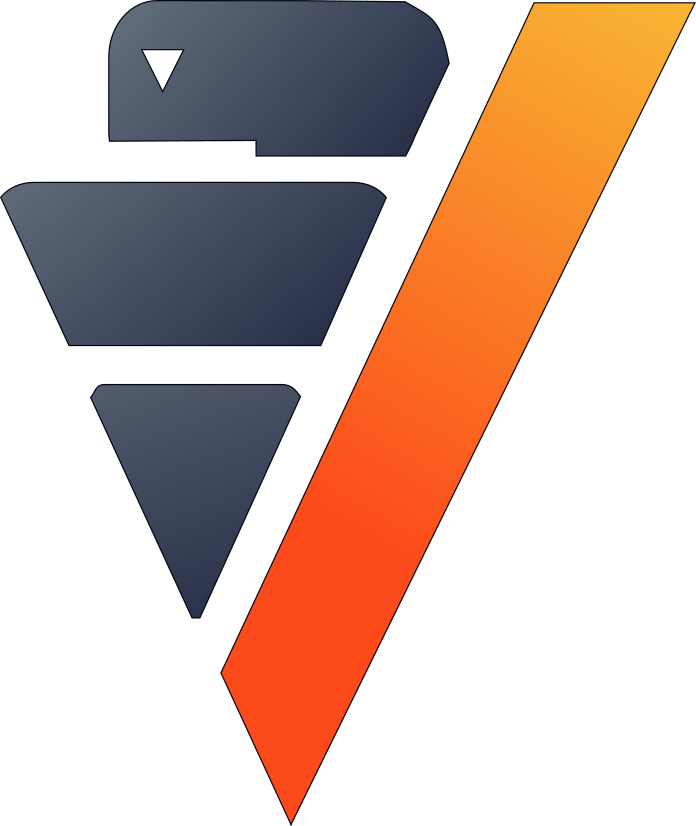

In [28]:
# define predictors and response
predictors = ['duration_minute', 
              'release_year', 
              'danceability', 
              'energy', 
              'loudness',
              'speechiness', 
              'acousticness', 
              'instrumentalness', 
              'liveness', 
              'valence', 
              'artists_followers', 
              'artist_popularity', 
              'nb_singers']
response = 'popularity'

# normalize the features
polish_tracks.normalize(method = "minmax",
                        columns = predictors)

# save the final dataset to the database
polish_tracks.to_db('"spotify"."polish_tracks_data_final"', relation_type = "table")

### Machine Learning

We can use AutoML to easily get a well-performing model.

In [29]:
# define a random seed so models tested by AutoML produce consistent results
vp.set_option("random_state", 2)

AutoML automatically tests several machine learning models and picks the best performing one.

In [30]:
from verticapy.learn.delphi import AutoML
# define the model
auto_model = AutoML('spotify.automl_spotify_polish',
                    estimator = "native",
                    preprocess_data = False,
                    stepwise = False,
                    cv = 2)

Train the model.

Starting AutoML




Testing Model - LinearRegression



Model: LinearRegression; Parameters: {'tol': 1e-06, 'max_iter': 100, 'solver': 'newton'}; Test_score: 8.066647640522543; Train_score: 8.118985304784605; Time: 0.20426690578460693;
Model: LinearRegression; Parameters: {'tol': 1e-06, 'max_iter': 100, 'solver': 'bfgs'}; Test_score: 8.06657408402635; Train_score: 8.118986556025963; Time: 0.7867480516433716;

Grid Search Selected Model
LinearRegression; Parameters: {'solver': 'bfgs', 'penalty': 'none', 'max_iter': 100, 'tol': 1e-06}; Test_score: 8.06657408402635; Train_score: 8.118986556025963; Time: 0.7867480516433716;

Testing Model - ElasticNet



Model: ElasticNet; Parameters: {'tol': 1e-06, 'max_iter': 100, 'solver': 'cgd', 'C': 1.0, 'l1_ratio': 0.5}; Test_score: 14.822426878049042; Train_score: 15.035727014744669; Time: 0.27442634105682373;

Grid Search Selected Model
ElasticNet; Parameters: {'solver': 'cgd', 'penalty': 'enet', 'max_iter': 100, 'l1_ratio': 0.5, 'C': 1.0, 'tol': 1e-06}; Test_score: 14.822426878049042; Train_score: 15.035727014744669; Time: 0.27442634105682373;

Testing Model - Ridge



Model: Ridge; Parameters: {'tol': 1e-06, 'max_iter': 100, 'C': 1.0}; Test_score: 8.064233984706952; Train_score: 8.121069572782197; Time: 0.20085954666137695;

Grid Search Selected Model
Ridge; Parameters: {'solver': 'newton', 'penalty': 'l2', 'max_iter': 100, 'C': 1.0, 'tol': 1e-06}; Test_score: 8.064233984706952; Train_score: 8.121069572782197; Time: 0.20085954666137695;

Testing Model - Lasso



Model: Lasso; Parameters: {'tol': 1e-06, 'max_iter': 100, 'solver': 'cgd', 'C': 1.0}; Test_score: 9.76754307664328; Train_score: 10.121086467655486; Time: 0.2544424533843994;

Grid Search Selected Model
Lasso; Parameters: {'solver': 'cgd', 'penalty': 'l1', 'max_iter': 100, 'C': 1.0, 'tol': 1e-06}; Test_score: 9.76754307664328; Train_score: 10.121086467655486; Time: 0.2544424533843994;

Testing Model - LinearSVR



Model: LinearSVR; Parameters: {'tol': 1e-06, 'fit_intercept': True, 'intercept_mode': 'regularized', 'max_iter': 100}; Test_score: 8.06441805263914; Train_score: 8.120720846232265; Time: 2.197774648666382;
Model: LinearSVR; Parameters: {'tol': 1e-06, 'fit_intercept': True, 'intercept_mode': 'unregularized', 'max_iter': 100}; Test_score: 8.065481552212296; Train_score: 8.119616043007014; Time: 2.323397994041443;
Model: LinearSVR; Parameters: {'tol': 1e-06, 'C': 1.0, 'fit_intercept': True, 'intercept_mode': 'regularized', 'max_iter': 100}; Test_score: 8.06441805263914; Train_score: 8.120720846232265; Time: 2.182707905769348;
Model: LinearSVR; Parameters: {'tol': 1e-06, 'C': 1.0, 'fit_intercept': True, 'intercept_mode': 'unregularized', 'max_iter': 100}; Test_score: 8.065481552212296; Train_score: 8.119616043007014; Time: 2.6499600410461426;

Grid Search Selected Model
LinearSVR; Parameters: {'tol': 1e-06, 'C': 1.0, 'max_iter': 100, 'fit_intercept': True, 'intercept_scaling': 1.0, 'interc

Model: RandomForestRegressor; Parameters: {'max_features': 'max', 'max_leaf_nodes': 128, 'max_depth': 5, 'min_samples_leaf': 1, 'min_info_gain': 0.0, 'nbins': 32}; Test_score: 7.113663323363556; Train_score: 6.39265180458105; Time: 0.42195308208465576;
Model: RandomForestRegressor; Parameters: {'max_features': 'max', 'max_leaf_nodes': 1000, 'max_depth': 5, 'min_samples_leaf': 1, 'min_info_gain': 0.0, 'nbins': 32}; Test_score: 7.113663323363556; Train_score: 6.39265180458105; Time: 0.3885120153427124;
Model: RandomForestRegressor; Parameters: {'max_features': 'max', 'max_leaf_nodes': 128, 'max_depth': 5, 'min_samples_leaf': 2, 'min_info_gain': 0.0, 'nbins': 32}; Test_score: 7.181553675673483; Train_score: 6.5483753528126805; Time: 0.40996646881103516;
Model: RandomForestRegressor; Parameters: {'max_features': 'max', 'max_leaf_nodes': 64, 'max_depth': 4, 'min_samples_leaf': 1, 'min_info_gain': 0.0, 'nbins': 32}; Test_score: 7.266855044387853; Train_score: 6.809449561850816; Time: 0.39678

model_type                                parameters   \\
1     RandomForestRegressor  {'n_estimators': 10, 'max_features': ...   \\
2     RandomForestRegressor  {'n_estimators': 10, 'max_features': ...   \\
3     RandomForestRegressor  {'n_estimators': 10, 'max_features': ...   \\
4     RandomForestRegressor  {'n_estimators': 10, 'max_features': ...   \\
5     RandomForestRegressor  {'n_estimators': 10, 'max_features': ...   \\
6                     Ridge  {'solver': 'newton', 'penalty': 'l2',...   \\
7                 LinearSVR  {'tol': 1e-06, 'C': 1.0, 'max_iter': ...   \\
8                 LinearSVR  {'tol': 1e-06, 'C': 1.0, 'max_iter': ...   \\
9                 LinearSVR  {'tol': 1e-06, 'C': 1.0, 'max_iter': ...   \\
10                LinearSVR  {'tol': 1e-06, 'C': 1.0, 'max_iter': ...   \\
11         LinearRegression  {'solver': 'bfgs', 'penalty': 'none',...   \\
12         LinearRegression  {'solver': 'newton', 'penalty': 'none...   \\
13                    Lasso  {'solver': 'cgd', 'penalty': 'l1', 'm...   \\
14               ElasticNet  {'solver': 'cgd', 'penalty': 'enet', ...   \\
               avg_score       avg_train_score               avg_time   \\
1      7.064327407880318     6.210967309985071     0.4239314794540405   \\
2      7.113663323363556      6.39265180458105    0.42195308208465576   \\
3      7.113663323363556      6.39265180458105     0.3885120153427124   \\
4      7.181553675673483    6.5483753528126805    0.40996646881103516   \\
5      7.266855044387853     6.809449561850816     0.3967854976654053   \\
6      8.064233984706952     8.121069572782197    0.20085954666137695   \\
7       8.06441805263914     8.120720846232265      2.197774648666382   \\
8       8.06441805263914     8.120720846232265      2.182707905769348   \\
9      8.065481552212296     8.119616043007014      2.323397994041443   \\
10     8.065481552212296     8.119616043007014     2.6499600410461426   \\
11      8.06657408402635     8.118986556025963     0.7867480516433716   \\
12     8.066647640522543     8.118985304784605    0.20426690578460693   \\
13      9.76754307664328    10.121086467655486     0.2544424533843994   \\
14    14.822426878049042    15.035727014744669    0.27442634105682373   \\
                 score_std        score_train_std                               model_class  
1     0.021951610316419245    0.05495843581963396  <class 'verticapy.learn.ensemble.Rand...  
2      0.04420745773425167    0.05405953173125159  <class 'verticapy.learn.ensemble.Rand...  
3      0.04420745773425167    0.05405953173125159  <class 'verticapy.learn.ensemble.Rand...  
4       0.0457345096188477    0.05011685394254436  <class 'verticapy.learn.ensemble.Rand...  
5      0.05954893368677364    0.20818778505776214  <class 'verticapy.learn.ensemble.Rand...  
6      0.15216905564050348     0.1513846089750132  <class 'verticapy.learn.linear_model....  
7      0.15018542501699342     0.1512890154897334   <class 'verticapy.learn.svm.LinearSVR'>  
8      0.15018542501699342     0.1512890154897334   <class 'verticapy.learn.svm.LinearSVR'>  
9      0.14813750528375574    0.15105738388572493   <class 'verticapy.learn.svm.LinearSVR'>  
10     0.14813750528375574    0.15105738388572493   <class 'verticapy.learn.svm.LinearSVR'>  
11      0.1451403695610597    0.15092076870560675  <class 'verticapy.learn.linear_model....  
12     0.14523553927522023    0.15092178039328827  <class 'verticapy.learn.linear_model....  
13      0.1918344551389224    0.22492932355164136  <class 'verticapy.learn.linear_model....  
14     0.00898900231672321    0.08108192620896942  <class 'verticapy.learn.linear_model....  
Rows: 1-14 | Columns: 8
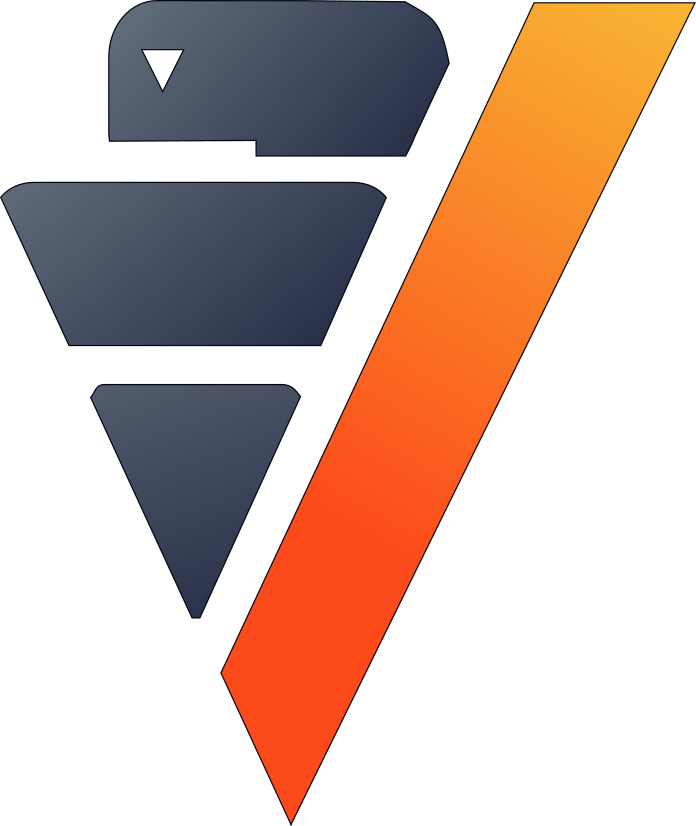

In [31]:
%%time
auto_model.fit('spotify.polish_tracks_data_final', 
               predictors, 
               response) 

The numbers are hard to grasp on their own, so let's plot the performance and efficiency of each model.

<AxesSubplot:xlabel='time', ylabel='score'>

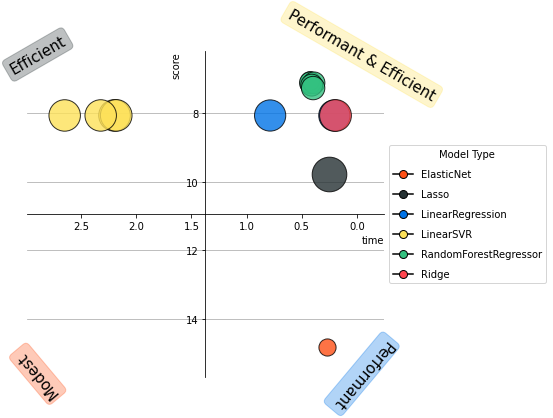

In [32]:
# visualize the performance of different models
auto_model.plot()

Extract the best model according to AutoML. From here, we can look at the model type and its hyperparameters.

In [33]:
# extract the model type and hyperparameters
best_model = auto_model.best_model_
bm_type = best_model.type
hyperparams = best_model.get_params()

print(bm_type)
print(hyperparams)

RandomForestRegressor
{'n_estimators': 10, 'max_features': 'max', 'max_leaf_nodes': 64, 'sample': 0.632, 'max_depth': 6, 'min_samples_leaf': 2, 'min_info_gain': 0.0, 'nbins': 32}


Thanks to AutoML, we know best model type and its hyperparameters. Let's create a new model with this information in mind.

id                                      name   \\
1      0004Uy71ku11n3LMpuyf59              24.11.94 - Wersja Akustyczna   \\
2      008UO76dicJJrUb5g6WID0                                       Maj   \\
3      00D7fT49Q54HNiaaLY32UA                               Arabska noc   \\
4      00De7REGurYkmfrKAh6CU1                    Dracula- The Beginning   \\
5      00KCwnrvIXX8GRU3ZMOIBW                    Désolée (Paris/Paname)   \\
6      00g7zzRDf2DOf4fKYzFTUA                                    Wiraże   \\
7      00i4Q7OfN0mGnUyuyQcAdZ  Pieseň Roxany a kadetov (Hráči mimo hry)   \\
8      00i4Q7OfN0mGnUyuyQcAdZ  Pieseň Roxany a kadetov (Hráči mimo hry)   \\
9      00l8ILQ8qgsew789dGn1Gh                                 Nyamaland   \\
10     00vlVv7WLZjyRS783REKmn                                    Upadek   \\
11     00wJpDUdKoWQ2ibqTpJh1Y                               Ze Mną Bądź   \\
12     010cqDI9IKD8f3Ji8TnT9h              Ballada o trzech trubadurach   \\
13     0123TtFcZ7pZIss52i7nAK                              Kocie Sprawy   \\
14     015JvDPIBquLQTX6VZPwB2             Kiedy znów zakwitną białe bzy   \\
15     01FN979nyz1gmdsfWZv5OL                             O Sobie Samym   \\
16     01LN8YM6L9V2a135AnhZqf                             Światłocienie   \\
17     01LN8YM6L9V2a135AnhZqf                             Światłocienie   \\
18     01j7wulLc7rJVk0STUPEKu                        Pyzate słoneczniki   \\
19     01lYEV7KZT34GOAW2MIgHF                             Jednego serca   \\
20     01uK4bh8p175iZj7uSkp5k                                   O Tobie   \\
21     025zlWO2FRZZrFhRw5kqa9                            Imperium UBOJU   \\
22     028DQ7NS44vnLRaoon0mwg                     Polska złota młodzież   \\
23     02GvdetV646M4C1Ip8CKg5               Muzyko z tamtej strony dnia   \\
24     02IpFuItRz1yXbYAtHsXJs                    Deszcz w Cisnej - 1976   \\
25     02JLJi7sryFu44hhNWOv1c                            Początek końca   \\
26     02RqhFaAYzWScfVzKfTZ7L                             Ramię W Ramię   \\
27     02hewGMWcG5Vp8nwhcmTA0                                Spalaj się   \\
28     02yg6Eksd8zZpYxsT1Lpsp                           Nie Jestem Soba   \\
29     03UV1fQG0MIm4CPszfttTJ                               Puste słowa   \\
30     04GlMx0s7MvdMr2MEXX8s8                       Kochać cię za późno   \\
31     04PxH7CFGAaAvo6j0zZAOr                                      Brać   \\
32     04PxH7CFGAaAvo6j0zZAOr                                      Brać   \\
33     04QM4iqGabg7QlphUoWiMB                     Dotyk (2020 Remaster)   \\
34     04izaHyfYxsE3AQ68kgB4I                                Barbarossa   \\
35     04kSSveBKXiNeRaOXu2iog                      Nie Ma Nie Ma Ciebie   \\
36     04wTGEh2gJTG72yUoizwFV                                 Bez szans   \\
37     053zfKbxSoqRm2RCdJdQMS                               Proletariat   \\
38     053zgCcuWJ9x4dJJgaF4VS                                Król Świtu   \\
39     054VUAvYt59A1yGSrBAgac                               Będzie dość   \\
40     05IAxc7j9T9KcEu0lAgbfB             Lubisz To Lubisz (Radio Edit)   \\
41     05JJTD8KdxbZsMnOn6imMv                 Gdzie Ten, Ktory Powie Mi   \\
42     05RcrI18Qi65dwc3vegSNP                    Echo - feat. Ewa Farna   \\
43     05hJSmfNiPXSzwSLeG1Rfb                              Czarne Serce   \\
44     05hk8ivnCt0HP3aI1uWJfi                                  Oranżada   \\
45     05v1D17vjtCNRyalBVGbKU                   Jeszcze W Zielone Gramy   \\
46     05yf5sbF36dhwGRfj18sg5                              Poland Story   \\
47     062pHiX7lpKRDmFvmJor3o               Spodnie z GS-u (The Butels)   \\
48     063FiQaY2FuZe3a44rZuSX                    Jak Dobrze Cię Widzieć   \\
49     063ZobFSzYA0O7fmfi4oik                               Pędzą Konie   \\
50     06AIE9kwssJ3cmPbMuHobb                                 Hipisówka   \\
51     06K6svVGbiQILn9BAzZNgo                               Każdy Dzień   \\
52     06LDaZRAWOc0fNqk
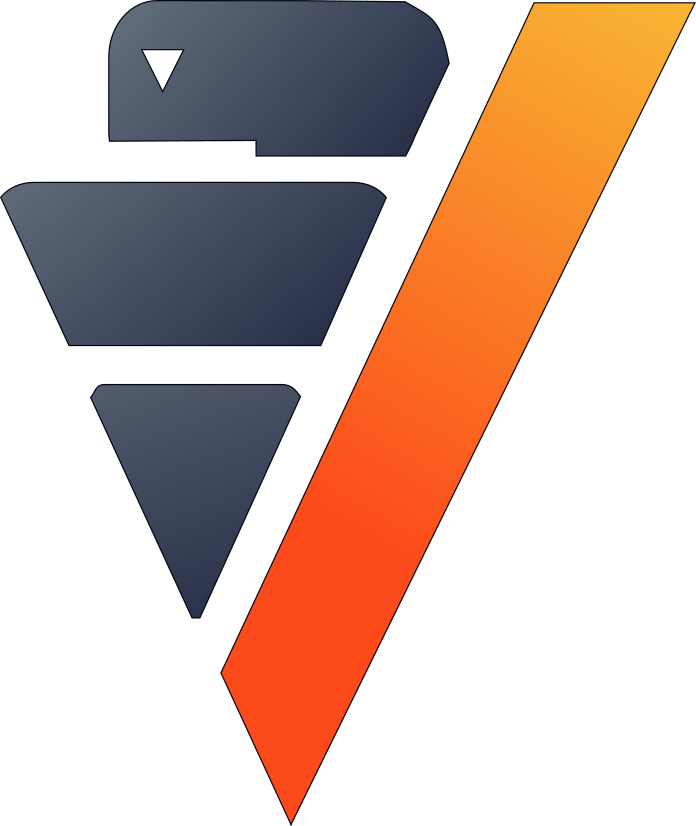

In [47]:
from verticapy.learn.ensemble import RandomForestRegressor

# define the model
rf_model = RandomForestRegressor('spotify.randomforest_spotify', **hyperparams)

# train the model
rf_model.fit(polish_tracks, predictors, response) 

# use the model to predict
rf_model.predict(polish_tracks, 
                 name = 'estimated_popularity')

View the regression report and the importance of each feature.

value  
explained_variance            0.856500452337576  
max_error                      35.5696078431373  
median_absolute_error          3.91965797527483  
mean_absolute_error            4.76133210498922  
mean_squared_error             39.2157935438824  
root_mean_squared_error       6.262251475618206  
r2                            0.856498475694773  
r2_adj                       0.8560006054476506  
aic                          13827.520352964559  
bic                           13914.66239558891  
Rows: 1-10 | Columns: 2
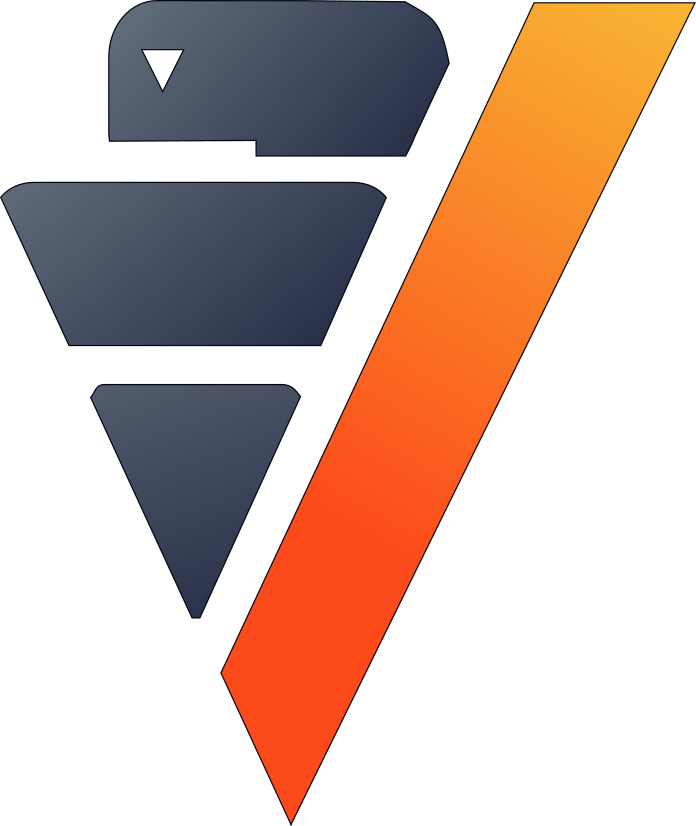

In [48]:
rf_model.regression_report()

importance    sign  
release_year                90.24       1  
artist_popularity            5.21       1  
instrumentalness             1.98       1  
artists_followers            0.54       1  
loudness                     0.54       1  
acousticness                 0.31       1  
energy                        0.3       1  
speechiness                  0.24       1  
duration_minute              0.21       1  
nb_singers                   0.13       1  
valence                      0.13       1  
danceability                  0.1       1  
liveness                     0.09       1  
Rows: 1-13 | Columns: 3
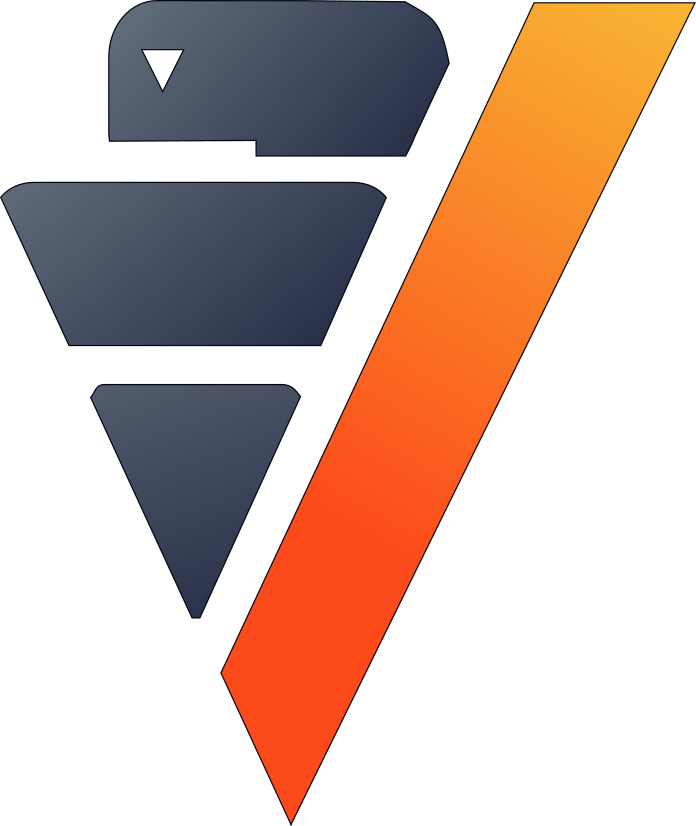

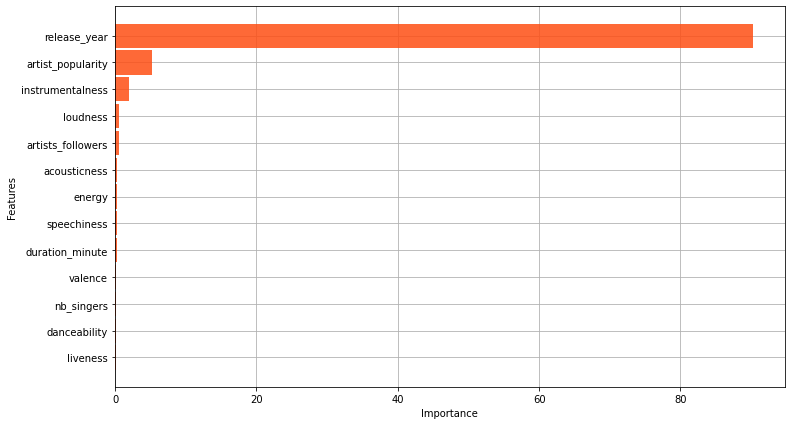

In [49]:
rf_model.features_importance()

To see how our model performs, let's plot the popularity and estimated popularity of songs by other Polish artists like Brodka, Akcent, and Maanam.

<AxesSubplot:xlabel='"name"'>

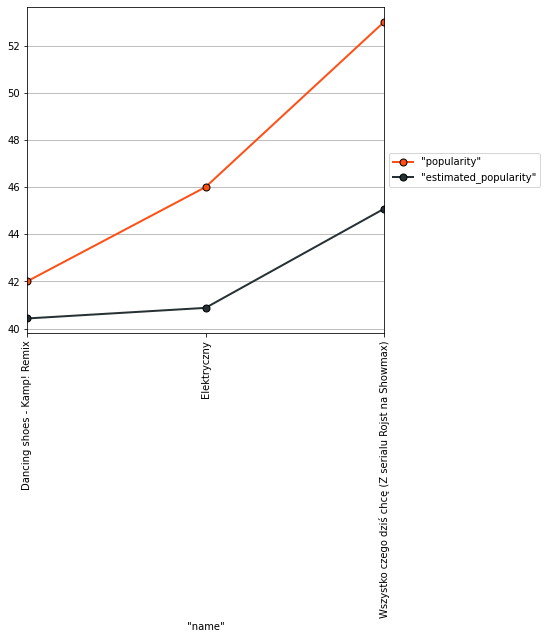

In [51]:
# results for Brodka
polish_tracks.search("LOWER(artists) LIKE '%brodka%'",
                     usecols = ['popularity', 'name', 'estimated_popularity']).plot(
                               ts='name', columns=['popularity', 'estimated_popularity'])

<AxesSubplot:xlabel='"name"'>

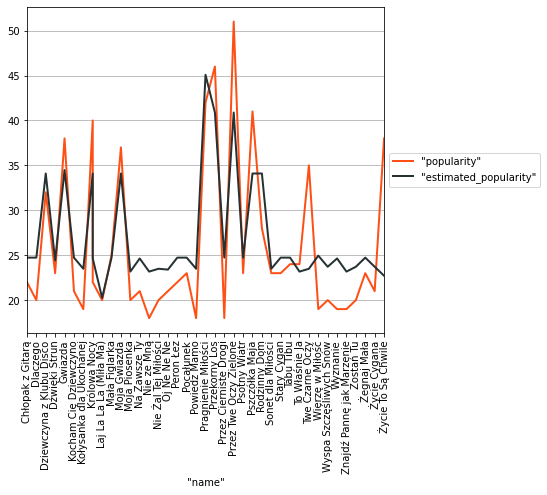

In [52]:
# results for Brodka
polish_tracks.search("LOWER(artists) LIKE '%akcent%'",
                     usecols = ['popularity', 'name', 'estimated_popularity']).plot(
                               ts='name', columns=['popularity', 'estimated_popularity'])

## Group Artists using Track Features

While our tracks don't have an explicit "genre" feature, we can approximate the effect by grouping artists based on their tracks' numerical features.

Let's start by taking the averages of these numerical features for each artist.

id_artists                                   artists   \\
1                  ['2h2nL9Hk4GQNcFm7fYV5ck']                                 ['Fokus']   \\
2    ['3jcmczo44yQB1kIDWe5gxY', '75LR4EwgI...  ['Paweł Bębenek', 'Dominikański Ośrod...   \\
3                  ['3PfkQWRO7rxkx0Z9Gs5MmB']                            ['Buzu Squat']   \\
4    ['1SKeSGQ3LMHYCEgqFGvJbE', '10JL3Ityc...  ['Krzysztof Krawczyk', 'Muniek Staszc...   \\
5    ['2gxtR1B9ivIaXO9LMR0R7X', '1nHXvuz8v...                     ['Verba', 'Rezerwat']   \\
6                  ['3iReVSIR5lImDswEWCMqAG']                               ['Dzamble']   \\
7                  ['1mmtkBkOsrKeOLJBQgFJoD']                      ['Power Of Trinity']   \\
8                  ['1qyadEaAHlRgdtf5F2YA4F']                          ['Sidney Polak']   \\
9    ['5bQZCiENsgmW4SvUOc86qI', '48ZMcpo8g...  ['Grzegorz Turnau', 'Andrzej Sikorows...   \\
10   ['03FgbE2vKKVEFBFHi8IfJG', '3MblUyzg5...               ['Chada', 'Hades', 'ZBUKU']   \\
11   ['4D22jVMhvZgzvt8Hh9AcKY', '2rfP10XRD...                       ['Brodka', 'A_GIM']   \\
12                 ['7IJs2eCpPWcUbaFtbZolhR']                                   ['PMM']   \\
13                 ['5ag7w8ET19zzERN4F5We42']                          ['Karin Stanek']   \\
14                 ['6jEmFzQnu1bB5tP23Jvw7e']                    ['Zdzisława Sośnicka']   \\
15                 ['3aCs1G6pzqfRCVhBdEoPBZ']                               ['Jauntix']   \\
16   ['4RoVw3AbSvjr1KFpzjBZgA', '4nRJJWVfb...  ['Josef Bratan', 'OLEK', 'Swizzy', 'M...   \\
17   ['5XKQ8fa0WdWBmgMFDmctCO', '4U3Mh4fpz...                 ['Vixen', 'Mery Spolsky']   \\
18   ['3bS0MLzGAoO6lLUy7gguHY', '37Pprth5H...              ['Fukaj', 'charlie moncler']   \\
19                 ['2rbgaZ9RvSFEApTsLPYLh5']                                ['Skaner']   \\
20                 ['3YKDQwFsJl1Y9oBDWeO8jh']                                  ['Hurt']   \\
21   ['3yCRvilOBzRkyxOsOi4tsR', '2v295z585...                   ['Viki Gabor', 'Kayah']   \\
22   ['5GwdnlZaSwKpHmjcAijATP', '3Mnrb43jb...                       ['Smolasty', 'Qry']   \\
23                 ['6wX80LLylzviIaxow8IDf0']                                 ['Armia']   \\
24   ['6uXPdkcF1OSFxmG7gF22rt', '1Kjs5u8GQ...  ['Abel de Jong', 'Malik Montana', 'Mr...   \\
25   ['7CJgLPEqiIRuneZSolpawQ', '6EB8VE9f7...  ['Taco Hemingway', 'Dawid Podsiadło',...   \\
26   ['5IQZA1dxUd3Qv73mHNln59', '5G2bin17k...                  ['Peja', 'Slums Attack']   \\
27   ['1HX9uYVwH6HHGyE8xSgtUD', '2hnyMG1Du...           ['Julia Wieniawa', 'Zeppy Zep']   \\
28                 ['4n44SROLP2vIR9HkYvwv8s']                              ['Limboski']   \\
29   ['7vYfq6OMlGDw1IpTxar2h2', '6EB8VE9f7...    ['Patrick the Pan', 'Dawid Podsiadło']   \\
30   ['6jEmFzQnu1bB5tP23Jvw7e', '4WNxiqxAH...  ['Zdzisława Sośnicka', 'Zbigniew Wode...   \\
31                 ['1efYxTvCNTpqYqfiEsxawq']                                 ['Jacuś']   \\
32                 ['5BrkebliJMRAGRPg8NRDGi']                               ['Szopeen']   \\
33                 ['3jDEqxckloWOCT1l7l1hJT']                        ['Andrzej Zaucha']   \\
34   ['7v49oVVUhvIQG5EK0jkcF7', '5mRRBVuAc...             ['PRO8L3M', 'Majka Jeżowska']   \\
35   ['56VhOZOF6hwqrbNYwkmcsH', '3gm9b6AeM...                        ['Sobel', 'Deemz']   \\
36   ['3gm9b6AeMf2eGQTLashkDt', '5GwdnlZaS...            ['Deemz', 'Smolasty', 'Sobel']   \\
37                 ['0RGqYHpCdjYsgMDeDYVSmm']                             ['Hans Solo']   \\
38   ['1A6HQzOvtGaCYihOuIKjE6', '4Q3xLVaD2...            ['Mr. Polska', 'Kabe', 'Kizo']   \\
39   ['5Q5WdRs96HgbxdVIfhHqt2', '6QfFTZJHF...             ['Borixon', 'Reto', 'Żabson']   \\
40                 ['0o7p9WUBNSwNwLXOi87H0y']                      ['Sława Przybylska']   \\
41                 ['24QgYKvd5QN6QFX7ZXEl40']                           ['Marek Dyjak']   \\
42   ['6gvVFtkTV4OCyQSCzGgU1h', '28oxY7ZfD...  ['Nik Tendo', 'Robin Zoot', 'Young Le...   \\
43                 ['3aMZqYBkJSpuNf0
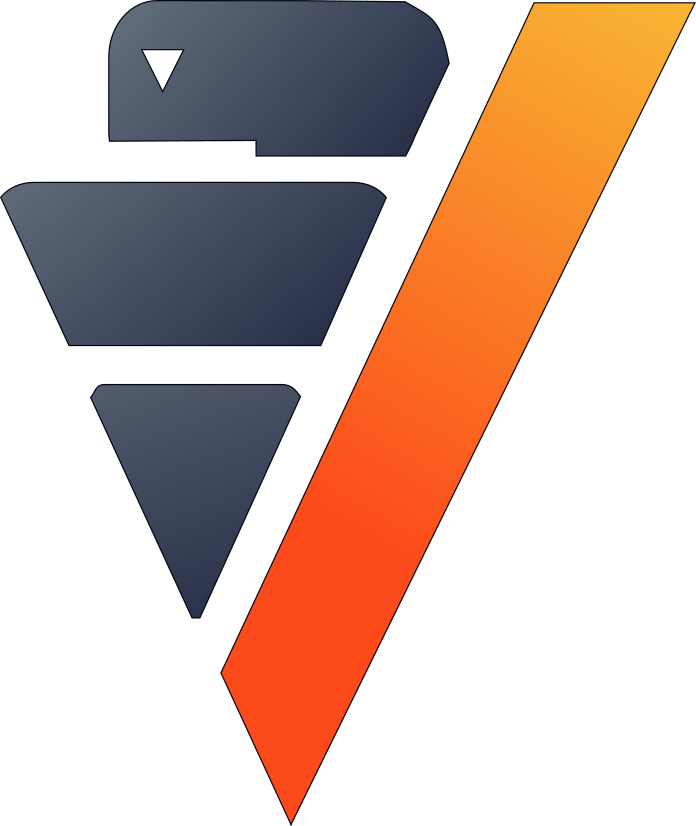

In [55]:
# group by artist
artists_features = polish_tracks.groupby(['id_artists',
                                          'artists'], expr=['AVG(danceability) AS danceability',
                                                            'AVG(energy) AS energy', 
                                                            'AVG(speechiness) AS speechiness', 
                                                            'AVG(acousticness) AS acousticness', 
                                                            'AVG(instrumentalness) AS instrumentalness',
                                                            'AVG(valence) AS valence', 
                                                            'AVG(liveness) AS liveness'])

# save relation to the database as "artists_features"
artists_features.to_db('"spotify"."artists_features"')

Grouping means clustering, so we use an elbow curve to find a suitable number of clusters.

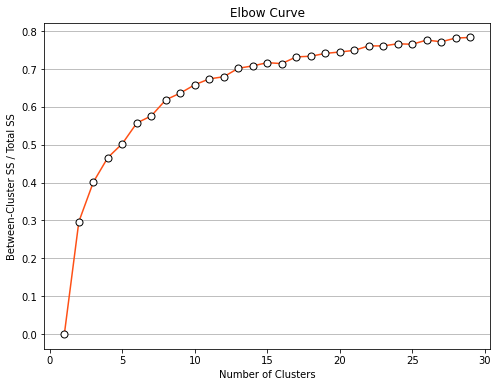

In [56]:
from verticapy.learn.model_selection import elbow

# define numerical features
preds = ["danceability",
         "energy",
         "speechiness",
         "acousticness",
         "instrumentalness",
         "liveness",
         "valence"]

# elbow curve
elbow = elbow('"spotify"."artists_features"',
              preds,
              n_cluster = (1, 30))

Let's define and use the Vertica k-means algorithm to create a model that can group artists together.

In [57]:
from verticapy.learn.cluster import KMeans

# define k-means
model = KMeans('"spotify"."KMeans_spotify"', 
               n_cluster = 7)

We can train our new model on the "artists_features" relation we saved earlier.

In [58]:
# train the model
model.fit('"spotify"."artists_features"', 
          X = preds)



centers
danceability| energy |speechiness|acousticness|instrumentalness|liveness|valence 
------------+--------+-----------+------------+----------------+--------+--------
   0.69555  | 0.78801|  0.10285  |   0.12729  |     0.01264    | 0.16900| 0.77472
   0.76995  | 0.64462|  0.27348  |   0.20702  |     0.00206    | 0.14808| 0.51245
   0.47486  | 0.36216|  0.03955  |   0.73322  |     0.01880    | 0.15942| 0.35397
   0.54658  | 0.69307|  0.06738  |   0.13429  |     0.09020    | 0.15264| 0.35517
   0.60919  | 0.75848|  0.17245  |   0.17270  |     0.06267    | 0.71443| 0.54388
   0.64666  | 0.63465|  0.15365  |   0.51753  |     0.01172    | 0.18339| 0.61588
   0.35545  | 0.24647|  0.02482  |   0.85935  |     0.78889    | 0.15544| 0.26981


metrics
Evaluation metrics:
     Total Sum of Squares: 236.02931
     Within-Cluster Sum of Squares: 
         Cluster 0: 19.761467
         Cluster 1: 12.785339
         Cluster 2: 12.796322
         Cluster 3: 23.034665
         Cluster 4: 5.882739

Plot the result of the k-means algoritm:

<AxesSubplot:xlabel='Dim1 (44.2%)', ylabel='Dim2 (18.6%)'>

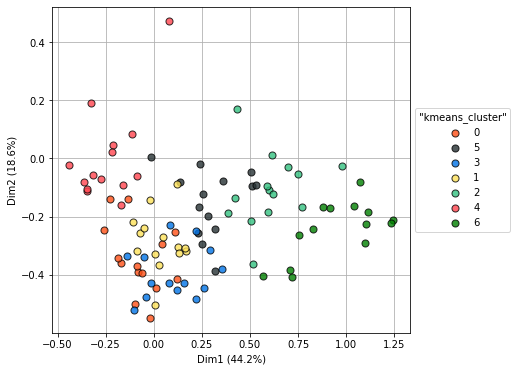

In [59]:
model.plot()

In [60]:
# predict the genres
pred_genres = model.predict('"spotify"."artists_features"', 
                            X = ["danceability",
                                 "energy",
                                 "speechiness",
                                 "acousticness",
                                 "instrumentalness",
                                 "liveness",
                                 "valence"], 
                            name="pred_genres")

Let's see how our model groups these artists together:

artists    pred_genres  
1                          ['Wojciech Kilar']              6  
2    ['Jan Maklakiewicz', 'Kazimierz Sikor...              6  
3    ['Jan Maklakiewicz', 'Kazimierz Sikor...              6  
4                        ['Wojciech Karolak']              6  
5    ['Frédéric Chopin', 'Janusz Olejniczak']              6  
6                       ['Zbigniew Preisner']              6  
7    ['Jascha Heifetz', 'Leopold Godowsky'...              6  
8    ['Jascha Heifetz', 'Leopold Godowsky'...              6  
9                            ['Laboratorium']              6  
10                        ['Mieczysław Kosz']              6  
11   ['Piotr Pałka', 'Dominikański Ośrodek...              6  
12   ['Wolfgang Amadeus Mozart', 'George S...              6  
13              ['Wojtek Mazolewski Quintet']              6  
14                     ['Andrzej Kurylewicz']              6  
15     ['Krzysztof Komeda', 'Leszek Możdżer']              6  
16           ['Zbigniew Namysłowski Quintet']              6  
17   ['Wojciech Kilar', 'Tadeusz Strugala'...              6  
18                    ['Włodzimierz Nahorny']              6  
19   ['Frédéric Chopin', 'Janusz Olejnicza...              6  
20   ['Marcin Wasilewski', 'Slawomir Kurki...              6  
21   ['Wolfgang Amadeus Mozart', 'Mieczysł...              6  
22   ['Ludwig van Beethoven', 'Mieczysław ...              6  
23                              ['Pati Yang']              6  
24                                  ['BOKKA']              6  
25                      ['Halina Frackowiak']              5  
26                         ['Domowe Melodie']              5  
27                         ['Beata Kozidrak']              5  
28                      ['Grammatik', 'Fisz']              5  
29   ['Bedoes', 'Kubi Producent', 'GOLEC U...              5  
30                  ['The Returners', 'Eldo']              5  
31                          ['Junior Stress']              5  
32               ['PRO8L3M', 'Sokół', 'Duit']              5  
33                 ['Jan-Rapowanie', 'Nocny']              5  
34                         ['Sobota', 'Kabe']              5  
35               ['Kamila Magálová', 'Vivat']              5  
36                        ['Sitara', 'Nazir']              5  
37   ['Katarzyna Sobczyk', 'Czerwono Czarni']              5  
38                            ['Anna Jantar']              5  
39   ['Popkiller Młode Wilki', 'Zeamsone',...              5  
40                                  ['Verba']              5  
41               ['Wiatr', 'Sobel', 'be vis']              5  
42                    ['Justyna Steczkowska']              5  
43                                 ['Aya RL']              5  
44                     ['Krzysztof Klenczon']              5  
45                   ['Szymi Szyms', 'OsaKa']              5  
46                        ['Donatan', 'Cleo']              5  
47                      ['Lilly Hates Roses']              5  
48                      ['Bass Astral x Igo']              5  
49            ['Bitamina', 'Dawid Podsiadło']              5  
50                                  ['Kayah']              5  
51               ['Białas', 'Solar', 'Beteo']              5  
52                ['Favst', 'Gibbs', 'Kukon']              5  
53     ['Taco Hemingway', 'Borucci', 'Lanek']              5  
54                           ['Maria Peszek']              5  
55                         ['Miyo', 'Bedoes']              5  
56                                ['Sistars']              5  
57                       ['Czerwony Tulipan']              5  
58      ['Polska Wersja', 'Bezczel', 'ZBUKU']              5  
59                                ['Pudelsi']              5  
60     ['White 2115', 'Chivas', 'Mr. Polska']              5  
61   ['Sobel', 'Czarny HIFI', 'Michał Szcz...              5  
62   ['Kubi Producent', 'Malik Montana', '...              5  
63        ['Jan-Rapowanie', 'Nocny', 'Holak']              5  
64    
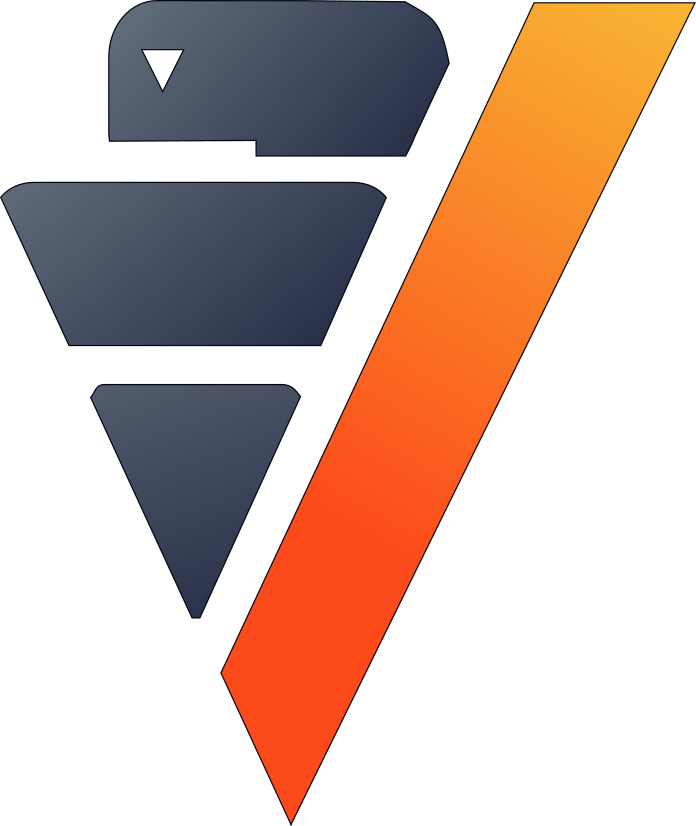

In [63]:
# observe the results
pred_genres['artists',
            'pred_genres'].sort({'pred_genres':'desc'})

## Conclusion

We were able to predict the popularity Polish songs with a RandomForestRegressor model suggested by AutoML. We then created a k-means model to group artists into "genres" (clusters) based on the feature-commonalities in their tracks.